In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from PIL import Image
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import zipfile

import torch.nn.functional as F
from rich.console import Console
from rich.progress import Progress, BarColumn, TimeElapsedColumn, TimeRemainingColumn
from rich.table import Table

import pandas as pd
from torch.cuda.amp import autocast, GradScaler


from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import numpy as np

In [2]:
# Install Git in case it's not available in your environment
!apt-get install git

# Clone the repository from GitHub
!git clone https://github.com/khairul-amin-cyber/CSE499-MerakiNexus-AI_And_Defi.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Cloning into 'CSE499-MerakiNexus-AI_And_Defi'...
remote: Enumerating objects: 8338, done.
remote: Counting objects: 100% (1178/1178), done.
remote: Compressing objects: 100% (798/798), done.
remote: Total 8338 (delta 1075), reused 384 (delta 380), pack-reused 7160 (from 2)
Receiving objects: 100% (8338/8338), 1.80 GiB | 35.94 MiB/s, done.
Resolving deltas: 100% (1241/1241), done.
Updating files: 100% (8652/8652), done.


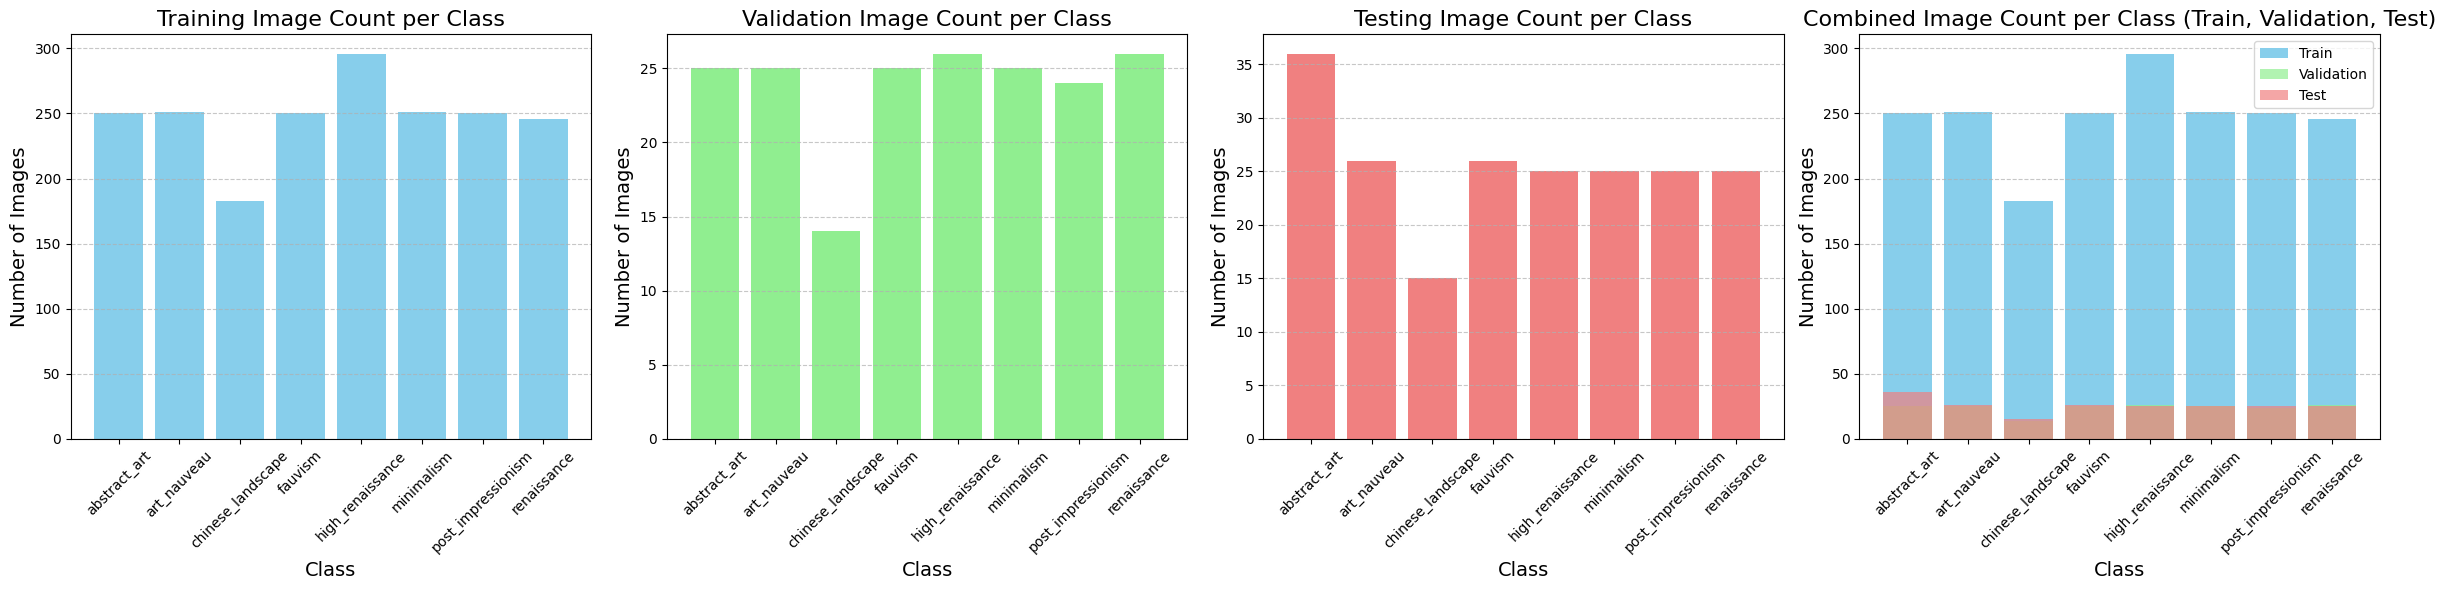

In [3]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets

# Define dataset path
dataset_path = "/content/CSE499-MerakiNexus-AI_And_Defi/aesthetic_model/aesthetic_dataset"  # Modify with your dataset path

# Load the datasets
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train")
val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val")
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test")

# Get class names and their corresponding folder paths
class_names = train_dataset.classes
train_image_counts = []
val_image_counts = []
test_image_counts = []

# Count the number of images in each class folder for all datasets
for class_name in class_names:
    # Count for training set
    train_class_folder = os.path.join(train_dataset.root, class_name)
    train_image_count = len(os.listdir(train_class_folder))  # Count files in each class folder
    train_image_counts.append(train_image_count)

    # Count for validation set
    val_class_folder = os.path.join(val_dataset.root, class_name)
    val_image_count = len(os.listdir(val_class_folder))  # Count files in each class folder
    val_image_counts.append(val_image_count)

    # Count for testing set
    test_class_folder = os.path.join(test_dataset.root, class_name)
    test_image_count = len(os.listdir(test_class_folder))  # Count files in each class folder
    test_image_counts.append(test_image_count)

# Plotting the class distribution for training, validation, and testing sets side by side
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Plot for training dataset
axes[0].bar(class_names, train_image_counts, color='skyblue')
axes[0].set_title('Training Image Count per Class', fontsize=16)
axes[0].set_xlabel('Class', fontsize=14)
axes[0].set_ylabel('Number of Images', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for validation dataset
axes[1].bar(class_names, val_image_counts, color='lightgreen')
axes[1].set_title('Validation Image Count per Class', fontsize=16)
axes[1].set_xlabel('Class', fontsize=14)
axes[1].set_ylabel('Number of Images', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for testing dataset
axes[2].bar(class_names, test_image_counts, color='lightcoral')
axes[2].set_title('Testing Image Count per Class', fontsize=16)
axes[2].set_xlabel('Class', fontsize=14)
axes[2].set_ylabel('Number of Images', fontsize=14)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for combined view (Training, Validation, and Testing)
axes[3].bar(class_names, train_image_counts, color='skyblue', label='Train')
axes[3].bar(class_names, val_image_counts, color='lightgreen', label='Validation', alpha=0.7)
axes[3].bar(class_names, test_image_counts, color='lightcoral', label='Test', alpha=0.7)
axes[3].set_title('Combined Image Count per Class (Train, Validation, Test)', fontsize=16)
axes[3].set_xlabel('Class', fontsize=14)
axes[3].set_ylabel('Number of Images', fontsize=14)
axes[3].tick_params(axis='x', rotation=45)
axes[3].legend()
axes[3].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()


In [8]:
# Mapping of sub-classes to main aesthetic classes (binary labels for each class)
class_to_main_class = {
    "abstract_art": [1, 0, 0, 0],  # Balance
    "art_nauveau": [1, 0, 0, 0],   # Balance
    "chinese_landscape": [0, 0, 0, 1],  # Texture & Brushwork
    "fauvism": [0, 1, 0, 0],  # Color Harmony
    "high_renaissance": [0, 0, 1, 0],  # Depth & Perspective
    "minimalism": [0, 0, 0, 1],  # Texture & Brushwork
    "post_impressionism": [0, 0, 1, 0],  # Depth & Perspective
    "renaissance": [0, 1, 0, 0]  # Color Harmony
}

# Custom Dataset to handle multi-label classification
class CustomAestheticDataset(datasets.ImageFolder):
    def __init__(self, root_dir, transform=None):
        super().__init__(root_dir, transform=transform)
        self.class_to_main_class = class_to_main_class

    def __getitem__(self, idx):
        img_path, class_idx = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(self.class_to_main_class[self.classes[class_idx]], dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, label

# Improved transformations for dataset
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset_path = "/content/CSE499-MerakiNexus-AI_And_Defi/aesthetic_model/aesthetic_dataset"  # Modify with your dataset path

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data = CustomAestheticDataset(root_dir=f"{dataset_path}/train", transform=transform)
val_data = CustomAestheticDataset(root_dir=f"{dataset_path}/val", transform=transform)
test_data = CustomAestheticDataset(root_dir=f"{dataset_path}/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)


Epoch 1/5 Training: 100%|██████████| 124/124 [00:51<00:00,  2.43batch/s, loss=1]


Epoch 1/5 completed in 51.04 seconds.
Epoch Loss: 1.7605163579986942
Train Accuracy: 79.50%


Epoch 1/5 Validation Accuracy: 81.48%


Epoch 2/5 Training: 100%|██████████| 124/124 [00:51<00:00,  2.39batch/s, loss=0.757]


Epoch 2/5 completed in 51.95 seconds.
Epoch Loss: 1.3406348247681894
Train Accuracy: 85.57%


Epoch 2/5 Validation Accuracy: 84.39%


Epoch 3/5 Training: 100%|██████████| 124/124 [00:51<00:00,  2.42batch/s, loss=4.1]


Epoch 3/5 completed in 51.14 seconds.
Epoch Loss: 1.191570343509797
Train Accuracy: 88.18%


Epoch 3/5 Validation Accuracy: 81.48%


Epoch 4/5 Training: 100%|██████████| 124/124 [00:50<00:00,  2.44batch/s, loss=1.88]


Epoch 4/5 completed in 50.88 seconds.
Epoch Loss: 1.2667449193616067
Train Accuracy: 86.54%


Epoch 4/5 Validation Accuracy: 79.23%


Epoch 5/5 Training: 100%|██████████| 124/124 [00:51<00:00,  2.42batch/s, loss=1.69]


Epoch 5/5 completed in 51.25 seconds.
Epoch Loss: 1.1728111866020388
Train Accuracy: 88.05%


Epoch 5/5 Validation Accuracy: 82.14%

Total Training Time: 276.43 seconds (4.61 minutes)


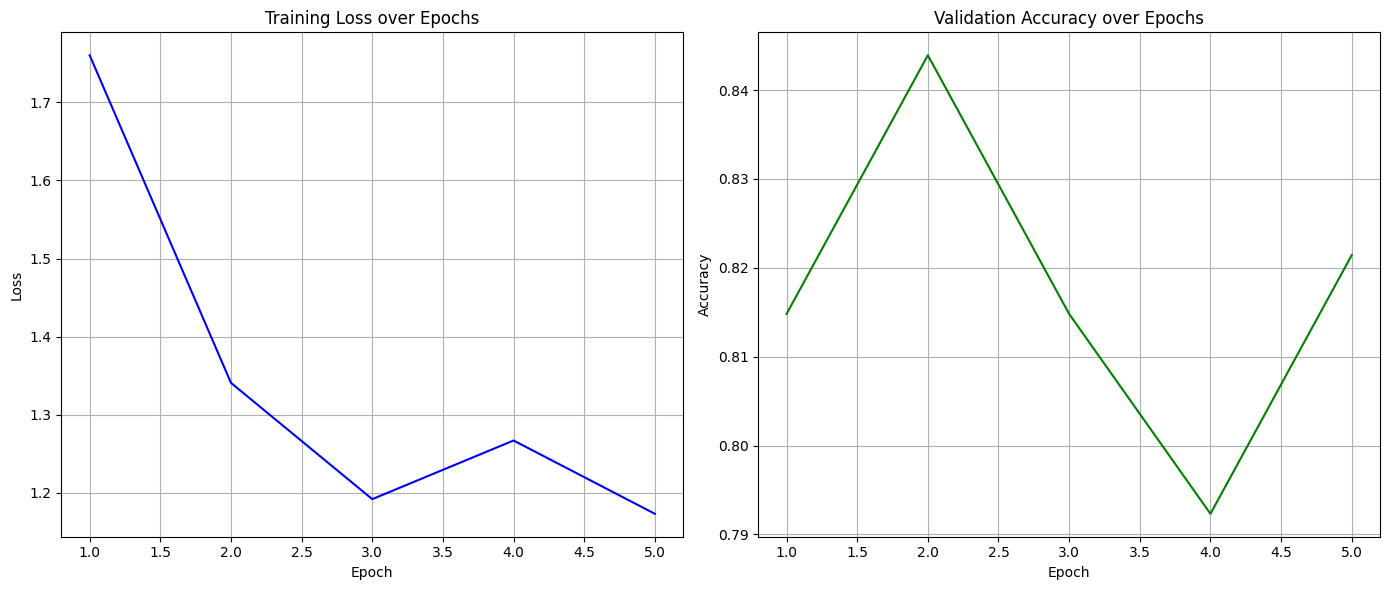

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm  # For ViT and other models
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch
import time
from tqdm import tqdm
from PIL import Image
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler
import os
import matplotlib.pyplot as plt

# Define aesthetic categories
aesthetic_categories = ["Balance", "Color Harmony", "Depth & Perspective", "Texture & Brushwork"]

# Define model based on ResNet50 with custom heads for the 4 aesthetic classes
class AestheticModelWithResNet50(nn.Module):
    def __init__(self, num_classes=4):
        super(AestheticModelWithResNet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)

        # Get the in_features from ResNet50's final fully connected layer
        in_features = self.resnet.fc.in_features

        # Remove the final fully connected layer (so that we can add custom heads)
        self.resnet.fc = nn.Identity()

        # Custom heads for the 4 aesthetic classes
        self.balance_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout for regularization
            nn.Linear(128, 1)  # Output for Balance class
        )

        self.color_harmony_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout for regularization
            nn.Linear(128, 1)  # Output for Color Harmony class
        )

        self.depth_perspective_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout for regularization
            nn.Linear(128, 1)  # Output for Depth & Perspective class
        )

        self.texture_brushwork_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout for regularization
            nn.Linear(128, 1)  # Output for Texture & Brushwork class
        )

    def forward(self, x):
        features = self.resnet(x)
        balance = self.balance_head(features)
        color_harmony = self.color_harmony_head(features)
        depth_perspective = self.depth_perspective_head(features)
        texture_brushwork = self.texture_brushwork_head(features)

        return balance, color_harmony, depth_perspective, texture_brushwork

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resNet50_model = AestheticModelWithResNet50(num_classes=4).to(device)
criterion = nn.BCEWithLogitsLoss()  # Suitable for multi-label classification

# Use AdamW optimizer for better regularization (weight decay) and improved performance
optimizer = optim.AdamW(resNet50_model.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler: CosineAnnealingLR
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-6)

# Training loop with progress bar and time tracking
num_epochs = 5
start_time = time.time()  # Start time for total training

train_losses = []
val_accuracies = []

# Early stopping criteria
best_val_accuracy = 0
patience = 5
no_improvement_epochs = 0

for epoch in range(num_epochs):
    resNet50_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_start_time = time.time()  # Start time for this epoch

    # Initialize tqdm progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            balance, color_harmony, depth_perspective, texture_brushwork = resNet50_model(images)

            # Calculate loss for each output (balance, color harmony, etc.)
            loss_balance = criterion(balance.squeeze(), labels[:, 0])
            loss_color_harmony = criterion(color_harmony.squeeze(), labels[:, 1])
            loss_depth_perspective = criterion(depth_perspective.squeeze(), labels[:, 2])
            loss_texture_brushwork = criterion(texture_brushwork.squeeze(), labels[:, 3])

            # Total loss is the sum of all losses
            total_loss = loss_balance + loss_color_harmony + loss_depth_perspective + loss_texture_brushwork
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            # Update accuracy
            predictions = torch.cat([
                torch.sigmoid(balance),
                torch.sigmoid(color_harmony),
                torch.sigmoid(depth_perspective),
                torch.sigmoid(texture_brushwork)
            ], dim=1)

            # Binarize predictions (thresholding at 0.5)
            predicted_labels = (predictions > 0.5).float()

            # Compare predicted labels with the ground truth labels
            correct_train += (predicted_labels == labels).sum().item()
            total_train += labels.size(0) * labels.size(1)  # Total labels for all 4 categories

            # Update the progress bar with loss information
            tepoch.set_postfix(loss=total_loss.item())

    epoch_end_time = time.time()  # End time for this epoch
    epoch_duration = epoch_end_time - epoch_start_time  # Duration of the epoch
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")
    print(f"Epoch Loss: {running_loss / len(train_loader)}")

    if total_train > 0:
        train_accuracy = correct_train / total_train  # Ensure division by non-zero total_train
        print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    else:
        print("Warning: Total train samples are zero.")

    train_losses.append(running_loss / len(train_loader))

    # Validation phase
    resNet50_model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            balance, color_harmony, depth_perspective, texture_brushwork = resNet50_model(images)

            # Convert logits to probabilities (using sigmoid)
            predictions_balance = torch.sigmoid(balance)
            predictions_color_harmony = torch.sigmoid(color_harmony)
            predictions_depth_perspective = torch.sigmoid(depth_perspective)
            predictions_texture_brushwork = torch.sigmoid(texture_brushwork)

            # Compare predictions to actual labels
            predicted_labels_balance = (predictions_balance > 0.5).float()
            predicted_labels_color_harmony = (predictions_color_harmony > 0.5).float()
            predicted_labels_depth_perspective = (predictions_depth_perspective > 0.5).float()
            predicted_labels_texture_brushwork = (predictions_texture_brushwork > 0.5).float()

            correct_val += (predicted_labels_balance == labels[:, 0].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_color_harmony == labels[:, 1].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_depth_perspective == labels[:, 2].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_texture_brushwork == labels[:, 3].unsqueeze(1)).sum().item()
            total_val += labels.size(0) * 4  # Total labels for all 4 categories

    val_accuracy = correct_val / total_val
    print(f"Epoch {epoch+1}/{num_epochs} Validation Accuracy: {val_accuracy * 100:.2f}%")
    val_accuracies.append(val_accuracy)

    # Check for early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        no_improvement_epochs = 0
        # Save the best model
        torch.save(resNet50_model.state_dict(), '/content/resNet50_best_model.pth')
    else:
        no_improvement_epochs += 1
        if no_improvement_epochs >= patience:
            print("Early stopping triggered.")
            break

    # Step the learning rate scheduler
    scheduler.step(running_loss)

# Total time for training
total_training_time = time.time() - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds ({(total_training_time / 60):.2f} minutes)")

# Plotting the Loss and Accuracy curves
plt.figure(figsize=(14, 6))

# Plot Training Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot Validation Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 1/10 Training: 100%|██████████| 124/124 [00:52<00:00,  2.37batch/s, loss=1.49]


Epoch 1/10 completed in 52.35 seconds.
Epoch Loss: 1.7748619817918347
Train Accuracy: 79.25%


Epoch 1/10 Validation Accuracy: 80.56%


Epoch 2/10 Training: 100%|██████████| 124/124 [00:51<00:00,  2.41batch/s, loss=2.52]


Epoch 2/10 completed in 51.42 seconds.
Epoch Loss: 1.332635477665932
Train Accuracy: 86.15%


Epoch 2/10 Validation Accuracy: 82.28%


Epoch 3/10 Training: 100%|██████████| 124/124 [00:51<00:00,  2.41batch/s, loss=0.52]


Epoch 3/10 completed in 51.52 seconds.
Epoch Loss: 1.208437956629261
Train Accuracy: 87.35%


Epoch 3/10 Validation Accuracy: 82.67%


Epoch 4/10 Training: 100%|██████████| 124/124 [00:51<00:00,  2.41batch/s, loss=1.46]


Epoch 4/10 completed in 51.51 seconds.
Epoch Loss: 1.2727811009653154
Train Accuracy: 86.66%


Epoch 4/10 Validation Accuracy: 81.75%


Epoch 5/10 Training: 100%|██████████| 124/124 [00:51<00:00,  2.39batch/s, loss=1.33]


Epoch 5/10 completed in 51.87 seconds.
Epoch Loss: 1.1179185557749964
Train Accuracy: 88.39%


Epoch 5/10 Validation Accuracy: 80.95%


Epoch 6/10 Training: 100%|██████████| 124/124 [00:51<00:00,  2.42batch/s, loss=4.5]


Epoch 6/10 completed in 51.28 seconds.
Epoch Loss: 0.9935289128653465
Train Accuracy: 90.30%


Epoch 6/10 Validation Accuracy: 83.20%


Epoch 7/10 Training: 100%|██████████| 124/124 [00:50<00:00,  2.44batch/s, loss=1.42]


Epoch 7/10 completed in 50.72 seconds.
Epoch Loss: 0.7955196886774032
Train Accuracy: 92.40%


Epoch 7/10 Validation Accuracy: 81.75%


Epoch 8/10 Training: 100%|██████████| 124/124 [00:51<00:00,  2.43batch/s, loss=1.1]


Epoch 8/10 completed in 51.07 seconds.
Epoch Loss: 1.0159946336380896
Train Accuracy: 89.80%


Epoch 8/10 Validation Accuracy: 80.95%


Epoch 9/10 Training: 100%|██████████| 124/124 [00:50<00:00,  2.45batch/s, loss=0.602]


Epoch 9/10 completed in 50.71 seconds.
Epoch Loss: 0.8221010810905888
Train Accuracy: 92.28%


Epoch 9/10 Validation Accuracy: 81.48%


Epoch 10/10 Training: 100%|██████████| 124/124 [00:52<00:00,  2.37batch/s, loss=1.06]


Epoch 10/10 completed in 52.39 seconds.
Epoch Loss: 0.9654310629252465
Train Accuracy: 90.56%


Epoch 10/10 Validation Accuracy: 81.08%

Total Training Time: 554.57 seconds (9.24 minutes)
Test Accuracy: 86.18%


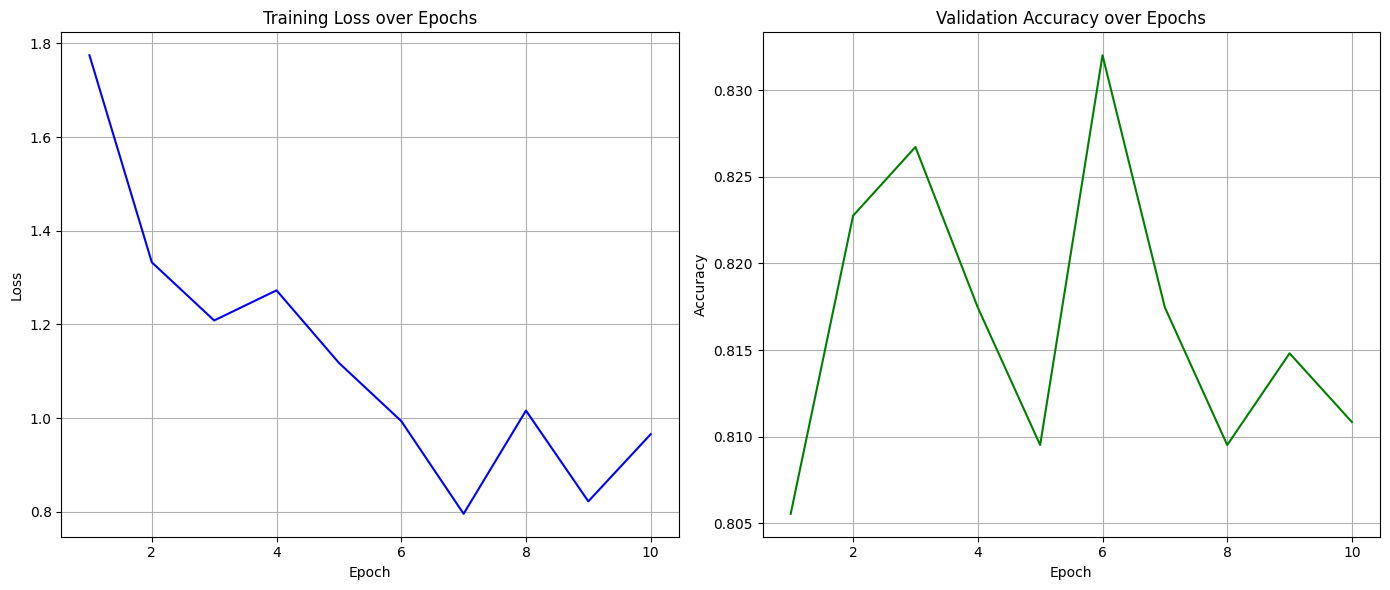

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from torchvision import datasets, models
from torch.cuda.amp import autocast, GradScaler

# Define aesthetic categories
aesthetic_categories = ["Balance", "Color Harmony", "Depth & Perspective", "Texture & Brushwork"]

# Define model based on ResNet50 with custom heads for the 4 aesthetic classes
class AestheticModelWithResNet50(nn.Module):
    def __init__(self, num_classes=4):
        super(AestheticModelWithResNet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)

        # Get the in_features from ResNet50's final fully connected layer
        in_features = self.resnet.fc.in_features

        # Remove the final fully connected layer (so that we can add custom heads)
        self.resnet.fc = nn.Identity()

        # Custom heads for the 4 aesthetic classes
        self.balance_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout for regularization
            nn.Linear(128, 1)  # Output for Balance class
        )

        self.color_harmony_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout for regularization
            nn.Linear(128, 1)  # Output for Color Harmony class
        )

        self.depth_perspective_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout for regularization
            nn.Linear(128, 1)  # Output for Depth & Perspective class
        )

        self.texture_brushwork_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout for regularization
            nn.Linear(128, 1)  # Output for Texture & Brushwork class
        )

    def forward(self, x):
        features = self.resnet(x)
        balance = self.balance_head(features)
        color_harmony = self.color_harmony_head(features)
        depth_perspective = self.depth_perspective_head(features)
        texture_brushwork = self.texture_brushwork_head(features)

        return balance, color_harmony, depth_perspective, texture_brushwork

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resNet50_model = AestheticModelWithResNet50(num_classes=4).to(device)
criterion = nn.BCEWithLogitsLoss()  # Suitable for multi-label classification

# Use AdamW optimizer for better regularization (weight decay) and improved performance
optimizer = optim.AdamW(resNet50_model.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler: CosineAnnealingLR
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-6)

# Training loop with progress bar and time tracking
num_epochs = 10
start_time = time.time()  # Start time for total training

train_losses = []
val_accuracies = []
train_accuracies = []
test_accuracies = []

# Early stopping criteria
best_val_accuracy = 0
patience = 5
no_improvement_epochs = 0

for epoch in range(num_epochs):
    resNet50_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_start_time = time.time()  # Start time for this epoch

    # Initialize tqdm progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            balance, color_harmony, depth_perspective, texture_brushwork = resNet50_model(images)

            # Calculate loss for each output (balance, color harmony, etc.)
            loss_balance = criterion(balance.squeeze(), labels[:, 0])
            loss_color_harmony = criterion(color_harmony.squeeze(), labels[:, 1])
            loss_depth_perspective = criterion(depth_perspective.squeeze(), labels[:, 2])
            loss_texture_brushwork = criterion(texture_brushwork.squeeze(), labels[:, 3])

            # Total loss is the sum of all losses
            total_loss = loss_balance + loss_color_harmony + loss_depth_perspective + loss_texture_brushwork
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            # Update accuracy
            predictions = torch.cat([
                torch.sigmoid(balance),
                torch.sigmoid(color_harmony),
                torch.sigmoid(depth_perspective),
                torch.sigmoid(texture_brushwork)
            ], dim=1)

            # Binarize predictions (thresholding at 0.5)
            predicted_labels = (predictions > 0.5).float()

            # Compare predicted labels with the ground truth labels
            correct_train += (predicted_labels == labels).sum().item()
            total_train += labels.size(0) * labels.size(1)  # Total labels for all 4 categories

            # Update the progress bar with loss information
            tepoch.set_postfix(loss=total_loss.item())

    epoch_end_time = time.time()  # End time for this epoch
    epoch_duration = epoch_end_time - epoch_start_time  # Duration of the epoch
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")
    print(f"Epoch Loss: {running_loss / len(train_loader)}")

    if total_train > 0:
        train_accuracy = correct_train / total_train  # Ensure division by non-zero total_train
        print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    else:
        print("Warning: Total train samples are zero.")

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation phase
    resNet50_model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            balance, color_harmony, depth_perspective, texture_brushwork = resNet50_model(images)

            # Convert logits to probabilities (using sigmoid)
            predictions_balance = torch.sigmoid(balance)
            predictions_color_harmony = torch.sigmoid(color_harmony)
            predictions_depth_perspective = torch.sigmoid(depth_perspective)
            predictions_texture_brushwork = torch.sigmoid(texture_brushwork)

            # Compare predictions to actual labels
            predicted_labels_balance = (predictions_balance > 0.5).float()
            predicted_labels_color_harmony = (predictions_color_harmony > 0.5).float()
            predicted_labels_depth_perspective = (predictions_depth_perspective > 0.5).float()
            predicted_labels_texture_brushwork = (predictions_texture_brushwork > 0.5).float()

            correct_val += (predicted_labels_balance == labels[:, 0].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_color_harmony == labels[:, 1].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_depth_perspective == labels[:, 2].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_texture_brushwork == labels[:, 3].unsqueeze(1)).sum().item()
            total_val += labels.size(0) * 4  # Total labels for all 4 categories

    val_accuracy = correct_val / total_val
    print(f"Epoch {epoch+1}/{num_epochs} Validation Accuracy: {val_accuracy * 100:.2f}%")
    val_accuracies.append(val_accuracy)

    # Check for early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        no_improvement_epochs = 0
        # Save the best model
        torch.save(resNet50_model.state_dict(), '/content/resNet50_best_model.pth')
    else:
        no_improvement_epochs += 1
        if no_improvement_epochs >= patience:
            print("Early stopping triggered.")
            break

    # Step the learning rate scheduler
    scheduler.step(running_loss)

# Total time for training
total_training_time = time.time() - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds ({(total_training_time / 60):.2f} minutes)")

# Test Accuracy Evaluation
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        balance, color_harmony, depth_perspective, texture_brushwork = resNet50_model(images)

        # Convert logits to probabilities
        predictions = torch.cat([
            torch.sigmoid(balance),
            torch.sigmoid(color_harmony),
            torch.sigmoid(depth_perspective),
            torch.sigmoid(texture_brushwork)
        ], dim=1)

        # Binarize predictions (threshold = 0.5)
        predicted_labels = (predictions > 0.5).float()

        # Compute accuracy
        correct_test += (predicted_labels == labels).sum().item()
        total_test += labels.numel()

# Compute final test accuracy
test_accuracy = correct_test / total_test * 100

# Display results
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Plotting the Loss and Accuracy curves
plt.figure(figsize=(14, 6))

# Plot Training Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot Validation Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()
